In [12]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

In [13]:
from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [14]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [15]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = 'experiments/resnet50_ft7_6gpu/config.yaml'
snapshot = 'experiments/resnet50_ft7_6gpu/snapshot/checkpoint_e2.pth'

In [16]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.7
cfg.TRACK.WINDOW_INFLUENCE = 0.42

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [17]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset/got-10k/val/GOT-10k_Val_000009'
# fn_gt = '~/dataset/got-10k/val/GOT-10k_Val_000009/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [18]:
def _iou(lhs, rhs):
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return I / (A - I)

In [19]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
    
#     if ii > 10:
#         break
#     break
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

    plt.imshow(t_img[:, :, ::-1])
    rect = plt.Rectangle((rbb[0], rbb[1]),
                         rbb[2],
                         rbb[3], fill=False,
                         edgecolor=[1, 0, 0], linewidth=3.5)
    plt.gca().add_patch(rect)
    
    gtbb = gt_seq[ii]
    rect = plt.Rectangle((gtbb[0], gtbb[1]),
                         gtbb[2],
                         gtbb[3], fill=False,
                         edgecolor=[0, 1, 0], linewidth=2.5)
    plt.gca().add_patch(rect)
    plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
    plt.clf()

Tracking started, total 725 frames.
Miss at frame 77


<Figure size 864x864 with 0 Axes>

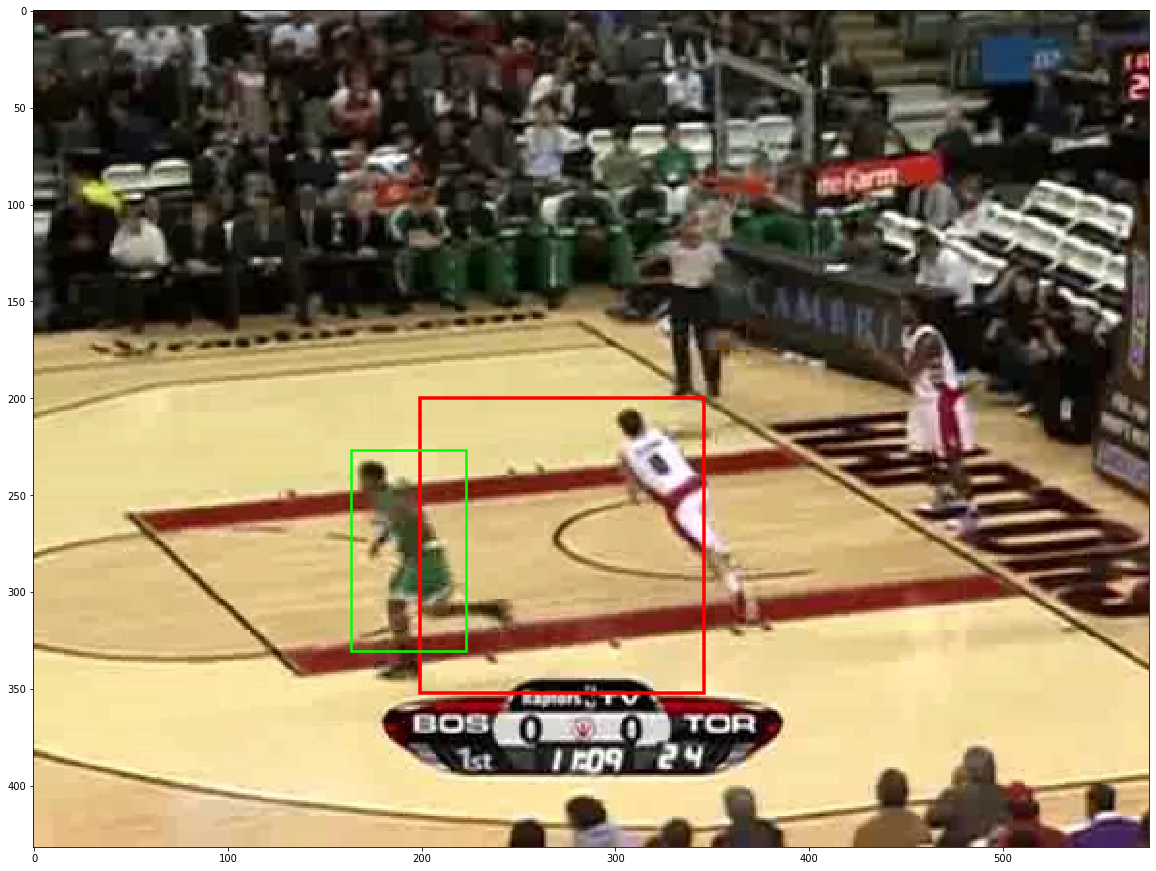

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

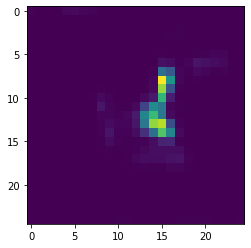

In [21]:
score = res['score'].reshape((5, 25, 25))
plt.imshow(np.max(score, axis=0))
plt.savefig('./result_images/{}/score_{:04d}.png'.format(test_name, ii))
# plt.close('all')

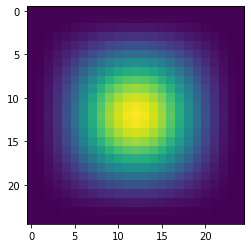

In [22]:
pscore = res['pscore'].reshape((5, 25, 25))
plt.imshow(np.max(pscore, axis=0))
plt.savefig('./result_images/{}/pscore_{:04d}.png'.format(test_name, ii))
# plt.close('all')

In [23]:
np.max(score)

0.0009840112